In [52]:
import requests,json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import Counter
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
warnings.filterwarnings('ignore')
from sklearn import tree

In [60]:
df_Crashes=pd.read_csv('/Users/wenlu/Downloads/Motor_Vehicle_Collisions_-_Crashes.csv')
df_vehicle=pd.read_csv('/Users/wenlu/Downloads/Motor_Vehicle_Collisions_-_Vehicles.csv')
df_person=pd.read_csv('/Users/wenlu/Downloads/Motor_Vehicle_Collisions_-_Person.csv')

In [7]:
print(df_Crashes.columns,df_vehicle.columns,df_person.columns)


Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object') Index(['UNIQUE_ID', 'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'VEHICLE_ID',
       'STATE_REGISTRATION', 'VEHICLE_TYPE', 'VEHICLE_MAKE', 'VEHICLE_MODEL',
       'VEHICLE_YEAR', 'TRAVEL_DIRECTION', 'VEHICLE_OCCUPANTS', 

In [8]:
df=df_Crashes.merge(df_person,on='COLLISION_ID')

Text(0.5, 1.0, 'Top 10 Most Common Vehicle Types')

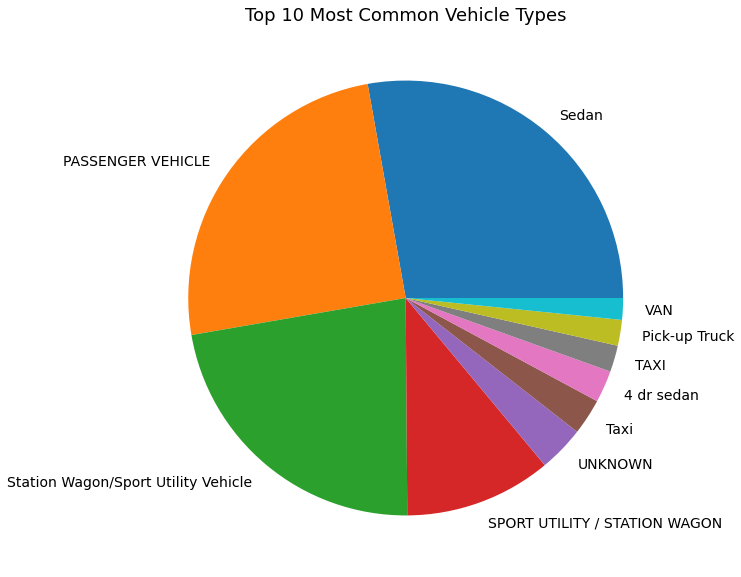

In [21]:
#df_vehicle['VEHICLE_TYPE'].value_counts()
fig = plt.figure(figsize = (10, 10))
ax = fig.subplots()
df_vehicle["VEHICLE_TYPE"].value_counts()[:10].plot(ax=ax, kind = "pie", textprops={'fontsize': 14})
ax.set_ylabel("")
ax.set_title("Top 10 Most Common Vehicle Types", fontsize=18)

In [27]:
df_vehicle['VEHICLE_YEAR_group']=np.where(df_vehicle['VEHICLE_YEAR']<2012,'10+y older','less 10y older')
df_vehicle['VEHICLE_YEAR_group'].value_counts()

less 10y older    2938225
10+y older         766181
Name: VEHICLE_YEAR_group, dtype: int64

In [40]:
df_vehicle['VEHICLE_OCCUPANTS'].value_counts()

1.0            1262475
0.0             324444
2.0             267377
3.0              76955
4.0              32637
                ...   
383.0                1
1739.0               1
999999999.0          1
1328.0               1
111.0                1
Name: VEHICLE_OCCUPANTS, Length: 120, dtype: int64

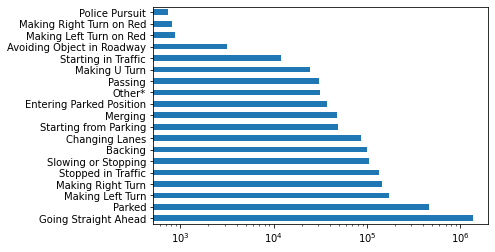

In [37]:
ax=df_vehicle['PRE_CRASH'].value_counts().plot(kind='barh')
ax.set_xscale('log')

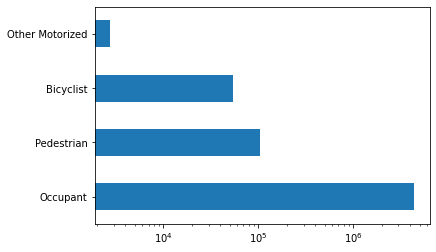

In [31]:
ax=df_person['PERSON_TYPE'].value_counts().plot(kind='barh')
ax.set_xscale('log')

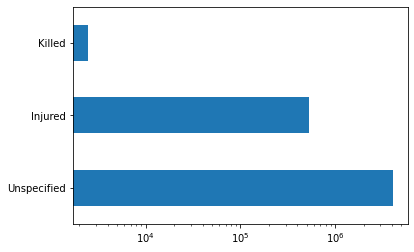

In [34]:
ax=df_person['PERSON_INJURY'].value_counts().plot(kind='barh')
ax.set_xscale('log')

In [61]:
num_people=df_person.groupby(by='COLLISION_ID').count()['UNIQUE_ID']

In [161]:
df_injured_rate=df_Crashes[['COLLISION_ID','NUMBER OF PERSONS INJURED','VEHICLE TYPE CODE 1']].merge(num_people.reset_index())
df_injured_rate['injured_rate']=df_injured_rate['NUMBER OF PERSONS INJURED']/df_injured_rate['UNIQUE_ID']
print("accident injuryed rate:",df_injured_rate['injured_rate'].mean())

accident injuryed rate: 0.18610818477028485


In [63]:
df_Crashes=df_Crashes.merge(df_injured_rate[['COLLISION_ID','injured_rate']],on='COLLISION_ID')

In [64]:
df_death_rate=df_Crashes[['COLLISION_ID','NUMBER OF PERSONS KILLED']].merge(num_people.reset_index())
df_death_rate['death_rate']=df_death_rate['NUMBER OF PERSONS KILLED']/df_death_rate['UNIQUE_ID']
print("accident death rate:",df_death_rate['death_rate'].mean())

accident death rate: 0.0009454612044603096


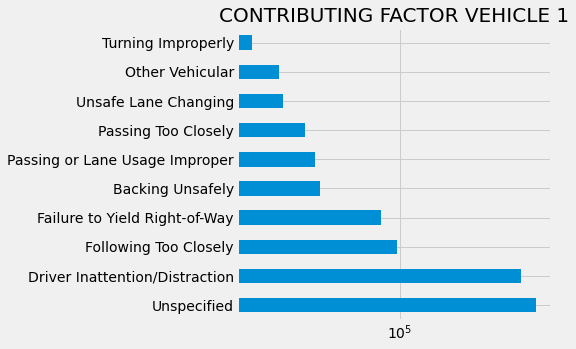

In [186]:
plt.figure(figsize=(5,5))
plt.title('CONTRIBUTING FACTOR VEHICLE 1', fontsize=20)
ax=df_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()[:10].plot(kind='barh')
ax.set_xscale('log')


In [197]:
df_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().index[:10]

Index(['Unspecified', 'Driver Inattention/Distraction',
       'Following Too Closely', 'Failure to Yield Right-of-Way',
       'Backing Unsafely', 'Passing or Lane Usage Improper',
       'Passing Too Closely', 'Unsafe Lane Changing', 'Other Vehicular',
       'Turning Improperly'],
      dtype='object')

In [192]:
df1=df_Crashes.groupby('CONTRIBUTING FACTOR VEHICLE 1')['injured_rate'].mean().reset_index().sort_values(by='injured_rate')

In [198]:
df1[df1['CONTRIBUTING FACTOR VEHICLE 1'].isin(df_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().index[:10])]

,CONTRIBUTING FACTOR VEHICLE 1,injured_rate
36,Passing Too Closely,0.020683
54,Unsafe Lane Changing,0.039767
37,Passing or Lane Usage Improper,0.042952
21,Following Too Closely,0.071259
6,Backing Unsafely,0.073820
53,Turning Improperly,0.114759
11,Driver Inattention/Distraction,0.140502
32,Other Vehicular,0.157388
18,Failure to Yield Right-of-Way,0.245537
56,Unspecified,0.275235


## Model development

In [65]:
df_Crashes=df_Crashes.merge(df_death_rate[['COLLISION_ID','death_rate']],on='COLLISION_ID')

In [88]:
df_Crashes['CRASH DATE'] = df_Crashes['CRASH DATE'].str[:10]
df_Crashes['CRASH DATE'] = pd.to_datetime(df_Crashes['CRASH DATE'], yearfirst = True)
df_Crashes['DAY OF WEEK'] = df_Crashes['CRASH DATE'].dt.day_name()

In [91]:
df_Crashes['Weekday_Weedken']=np.where((df_Crashes['DAY OF WEEK']=='Sunday')|(df_Crashes['DAY OF WEEK']=='Saturday'),'Weekend','Weekday')

In [92]:
df_Crashes["CRASH HOUR"] = pd.to_numeric(pd.to_datetime(df_Crashes['CRASH TIME'], format='%H:%M').dt.hour)

In [93]:
df_Crashes=pd.get_dummies(df_Crashes, columns=["Weekday_Weedken"])

In [66]:
df_Crashes['V group']=np.where((df_Crashes['VEHICLE TYPE CODE 1']=='Sedan')|(df_Crashes['VEHICLE TYPE CODE 1']=='SPORT UTILITY / STATION WAGON')|(df_Crashes['VEHICLE TYPE CODE 1']=='PASSENGER VEHICLE')|(df_Crashes['VEHICLE TYPE CODE 1']=='Station Wagon/Sport Utility Vehicle')|(df_Crashes['VEHICLE TYPE CODE 1']=='Taxi'),df_Crashes['VEHICLE TYPE CODE 1'],'others')
df_Crashes=pd.get_dummies(df_Crashes, columns=["V group"])
df_Crashes=pd.get_dummies(df_Crashes, columns=["BOROUGH"])

In [157]:
df_Crashes_train_death=df_Crashes[['BOROUGH_BRONX', 'BOROUGH_BROOKLYN',
       'BOROUGH_MANHATTAN', 'BOROUGH_QUEENS', 'BOROUGH_STATEN ISLAND','V group_PASSENGER VEHICLE', 'V group_SPORT UTILITY / STATION WAGON',
       'V group_Sedan', 'V group_Station Wagon/Sport Utility Vehicle',
       'V group_Taxi', 'V group_others','death_rate','Weekday_Weedken_Weekday','Weekday_Weedken_Weekend','CRASH HOUR']].dropna(inplace=False).copy()

In [124]:
df_Crashes_train_injured=df_Crashes[['BOROUGH_BRONX', 'BOROUGH_BROOKLYN',
       'BOROUGH_MANHATTAN', 'BOROUGH_QUEENS', 'BOROUGH_STATEN ISLAND','V group_PASSENGER VEHICLE', 'V group_SPORT UTILITY / STATION WAGON',
       'V group_Sedan', 'V group_Station Wagon/Sport Utility Vehicle',
       'V group_Taxi', 'V group_others','injured_rate','Weekday_Weedken_Weekday','Weekday_Weedken_Weekend','CRASH HOUR']].dropna(inplace=False).copy()

In [158]:
Y = df_Crashes_train_death[df_Crashes_train_death['V group_PASSENGER VEHICLE']==1]['death_rate']
X = df_Crashes_train_death[df_Crashes_train_death['V group_PASSENGER VEHICLE']==1].drop(['death_rate'],axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
depth = 3
clf = tree.DecisionTreeRegressor(criterion='squared_error', max_depth=depth) # gini, entropy
clf_result = clf.fit(X_train, y_train)

In [164]:
Y = df_Crashes_train_injured['injured_rate']
X = df_Crashes_train_injured.drop(['injured_rate'],axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
depth = 3
clf = tree.DecisionTreeRegressor(criterion='squared_error', max_depth=depth) # gini, entropy
clf_result = clf.fit(X_train, y_train)

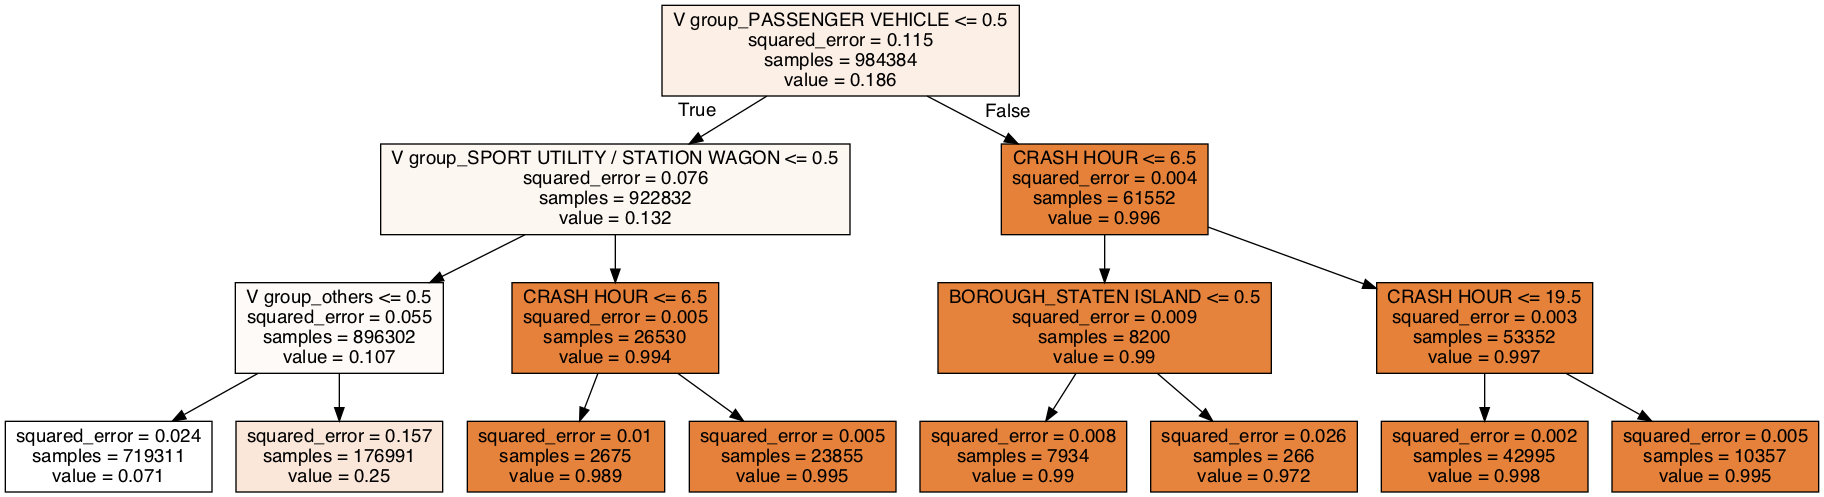

In [177]:
import pydotplus 
from IPython.display import Image
dot_data = tree.export_graphviz(clf_result, feature_names=X.columns,  filled=True, 
                                out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

In [165]:
#DecisionTreeRegressor()
score = clf.score(X_train, y_train)
print("R-squared:", score)

score = clf.score(X_test, y_test)
print("R-squared:", score)
ypred = clf.predict(X_test)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

# clf.predict(X_test)


R-squared: 0.5999291003206773
R-squared: 0.5914277206778242
MSE:  0.04738724542412725
RMSE:  0.023693622712063624
